In [1]:
%pylab inline --no-import-all
import cv2
import os

Populating the interactive namespace from numpy and matplotlib


In [720]:
def to_degrees(angle):
    return int(angle * 180 / np.pi)

def to_radians(angle):
    return angle / 180 * np.pi

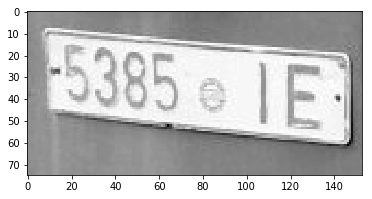

In [721]:
plates_dir = "data/borders/"
plate_file = os.path.join(plates_dir, os.listdir(plates_dir)[11])
img = cv2.imread(plate_file, cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')

In [722]:
def bounded(val, low, high):
    if val < low:
        return low
    elif val > high:
        return high
    else:
        return val
    
def get_lines(img, percentage, threshold, min_angle=0.00001, max_angle=np.pi,
              dilation_kernel=(1, 1), max_angle_diff=2*np.pi, max_len_diff=1000,
              show=False, plot_line_size=2, plot_bad_lines=False):

    edges = cv2.Canny(img, 150, 220)
    edges = edgesHor = cv2.dilate(edges, cv2.getStructuringElement(cv2.MORPH_RECT, dilation_kernel))
    height, width = img.shape

    hough_lines = cv2.HoughLines(edges, 1, np.pi/90, threshold, min_theta=min_angle, max_theta=max_angle)
    if hough_lines is None:
        return 0, []
    lines_count = int(np.ceil(percentage * len(hough_lines)))
    hough_lines = hough_lines[:lines_count]
    
    if show:
        img_copy = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        edges_copy = cv2.cvtColor(edgesHor, cv2.COLOR_GRAY2RGB)

    h = height - 1
    w = width - 1
    lines = []
    angles = []

    for i, (rho, theta) in enumerate(hough_lines[:, 0]):            
        sin = np.sin(theta)
        cos = np.cos(theta)
        tan = np.tan(theta)
        y0 = rho * sin
        x0 = rho * cos
        skew = x0*y0 > 0

        x1 = bounded(rho/cos, 0, w)
        y1 = bounded(rho/sin, 0, h)

        x2 = bounded(rho/cos - h*tan, 0, w)
        y2 = bounded(rho/sin - w/tan, 0, h)
        
        if skew and y2 < y1:
            x1, x2 = x2, x1
        if not skew and y2 > y2:
            x1, x2 = x2, x1

        length = np.sqrt((y1-y2)**2 + (x1-x2)**2)
        line = [(int(x1), int(y1)), (int(x2), int(y2))], (rho, theta)

        if i == 0:
            etalon_len = length
            etalon_angle = theta

        if np.abs(etalon_angle - theta) > max_angle_diff:
            color = (0, 0, 150)
            good = False
        elif np.abs(length - etalon_len) > max_len_diff:
            color = (150, 0, 0)
            good = False
        else:
            color = (0, 150, 0)
            good = True
            lines.append(line)
        angles.append(theta)
        
        if show and (plot_bad_lines or good):
            linesize = plot_line_size if good else 1
            cv2.line(img_copy, *line[0], color, linesize)
            cv2.line(edges_copy, *line[0], color, linesize)

    
    if show:
        Fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        ax1.imshow(img_copy)
        ax2.imshow(edges_copy)
    
    return lines

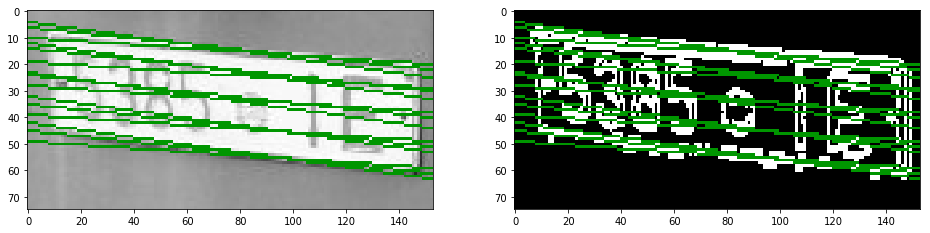

In [723]:
width, height = img.shape

hor_lines = get_lines(img, 1, width//2, dilation_kernel=(1, 3),
                      max_angle_diff=to_radians(3), max_len_diff=width//8,
                      show=True, plot_line_size=1, plot_bad_lines=False)

In [724]:
topline, topline_parametric = min(hor_lines, key=lambda l: l[0][0][1] + l[0][1][1])
bottomline, bottomline_parametric = max(hor_lines, key=lambda l: l[0][0][1] + l[0][1][1])

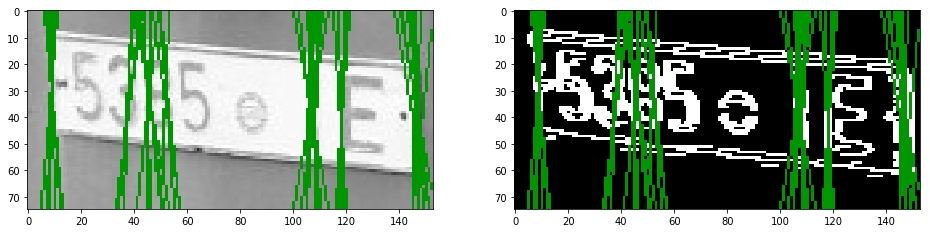

In [725]:
angle = np.mean((topline_parametric[1], bottomline_parametric[1]))
normal_angle = np.pi/2 + angle

min_angle = normal_angle - np.pi/12
max_angle = normal_angle + np.pi/12

ver_lines = get_lines(img, 1, int(0.2*height),
                                 min_angle=min_angle, max_angle=max_angle,
                                 max_angle_diff=to_radians(15),
                                 dilation_kernel=(3, 1),
                                 show=True, plot_line_size=1)

In [726]:
leftline, leftline_parametric = min(ver_lines, key=lambda l: l[0][0][0] + l[0][1][0])
rightline, rightline_parametric = max(ver_lines, key=lambda l: l[0][0][0] + l[0][1][0])

sortkey = lambda l: l[1] # sort by Y axis
leftline = sorted(leftline, key=sortkey)
rightline = sorted(rightline, key=sortkey)

In [727]:
def intersection_cart(line1, line2):
    (x1, y1), (x2, y2) = line1
    (x3, y3), (x4, y4) = line2
    
    d1 = (x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4)
    d2 = (x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4)
    d = (x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4)
        
    x = d1 / d
    y = d2 / d
    
    return int(x), int(y)

def intersections(img, topline, bottomline, leftline, rightline):
    img_copy = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    for line in (topline, bottomline, rightline, leftline):
        cv2.line(img_copy, *line, (0, 150, 0), 2)

    points = []
    for l1, l2 in [(topline, leftline), (topline, rightline), (bottomline, rightline), (bottomline, leftline)]:
        point = intersection_cart(l1, l2)
        cv2.circle(img_copy, point, 2, (255, 0, 0), -1)
        points.append(point)

    plt.imshow(img_copy)
    return points

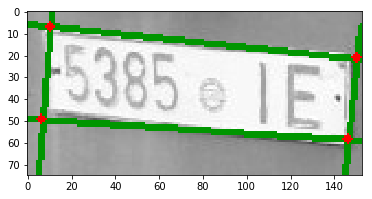

In [728]:
points = intersections(img, topline, bottomline, leftline, rightline)

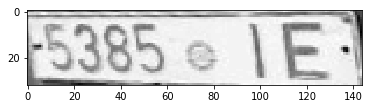

In [729]:
rect_from = np.array([
    points
], dtype=np.float32)
rect_to = np.array([
    [0, 0], [144, 0], [144, 32], [0, 32]
], dtype=np.float32)

transform = cv2.getPerspectiveTransform(rect_from, rect_to)

transformed = cv2.warpPerspective(img, transform, (144, 32))
plt.imshow(transformed, cmap='gray')